## Thermodynamics
### Phase equilibrium
##### UNIFAC method - Activity coefficient

In [1]:
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Molecular group data, extracted from the course material.

In [2]:
groups = { # main: {secondary i:[molecule,R,Q],secondary i+1:[molécula,R,Q],etc}
    1: {1:['CH3',0.9011,0.848],2:['CH2',0.6744,0.540],3:['CH',0.4469,0.228],4:['C',0.2195,0]},
    2: {5:['CH2CH',1.3454,1.176],6:['CHCH',1.1167,0.867],7:['CH2C',1.1173,0.988],8:['CHC',0.8886,0.676],70:['CC',0.6605,0.485]},
    3: {9:['ACH',0.5313,0.400],10:['AC',0.3652,0.120]},
    4: {11:['ACCH3',1.2663,0.968],12:['ACCH2',1.0396,0.660],13:['ACCH',0.8121,0.348]},
    5: {14:['OH',1.000,1.200]},
    6: {15:['CH3OH',1.4311,1.432]},
    7: {16:['H2O',0.9200,1.400]},
    8: {17:['ACOH',0.8952,0.680]},
    9: {18:['CH3CO',1.6724,1.488],19:['CH2CO',1.4457,1.180]},
    10: {20:['CHO',0.9980,0.948]},
    11: {21:['CH3COO',1.9031,1.728],22:['CH2COO',1.6764,1.420]},
    12: {23:['HCOO',1.2420,1.188]}
}
g_groups = {}
for i in groups.values():
    g_groups.update(i)
    
a_mn = pd.read_csv('a-mn.csv', sep=';', index_col=0)
a_mn.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,0.00,8602.000,61.13,76.50,986.5,697.2,1318.0,1333.0,476.40,677.0,232.100,507.0,251.50,391.500,255.70,206.60,920.70,287.800
2,-35.36,0.000,38.81,74.15,524.1,787.6,270.6,526.1,182.60,448.8,37.850,333.5,214.50,240.900,163.90,61.11,749.30,2811.500
3,-11.12,3.446,0.00,167.00,636.1,637.4,903.8,1329.0,25.77,347.3,5.994,287.1,32.14,161.700,122.80,9049.00,648.20,-4.449
4,-69.70,-113.600,-146.80,0.00,803.2,603.3,5695.0,4.9,-52.10,586.8,5688.000,197.8,213.10,19.020,-49.29,23.50,663.20,52.800
5,156.40,457.000,89.60,25.82,0.0,-137.1,353.5,-259.7,84.00,-203.6,101.100,267.8,28.06,8.642,42.70,-3210.00,-52.39,170.000


## UNIFAC Method
#### >> brief explanation goes here <<

**Molecule class and it's methods:**
* initializer - molecular group code and its respective amount

\> **combinatiorial activity coefficient** - _the easy one, be like it_
* r, q and l coefficients
* $\phi$ and $\theta$ factors
* $\gamma^c$- combinatorial activity coefficient

\> **residual activity coefficient** - _the hard one, don't be this one_
* $\psi$ factor
* $\Gamma_k$, X and $\theta$
* $\Gamma_k^i$, $X^i$ and $\theta^i$
        
$$\ln{\gamma^r} = \sum \nu_k (\ln\Gamma_k - \ln\Gamma_k^i)$$

\> **acitivity coefficient**

$$\ln{\gamma} = \ln{\gamma^c} + \ln{\gamma^r}$$

In [40]:
class molecule():
    def __init__(self,molGroups):
        self.g = molGroups.keys()
        self.v = molGroups.values()
        self.groups = molGroups        
        
    def rql(self):
        z,r,q = 10,0,0        
        num = len(self.g)
        if num > 1:
            for i,k in zip(self.g,self.v):
                r += g_groups[i][1] * k
                q += g_groups[i][2] * k
        else:
            r = g_groups[tuple(self.g)[0]][1] * tuple(self.v)[0]
            q = g_groups[tuple(self.g)[0]][2] * tuple(self.v)[0]
        self.l = 0.5 * z * (r - q) - (r - 1)
        self.r,self.q = r,q
        return(self.r,self.q,self.l)
    
    def phi_theta(self, fluid):
        phi,theta = {},{}       
        phi[self] = self.r * x / (self.r * x + fluid.r * (1 - x))
        phi[fluid] = fluid.r * (1 - x) / (self.r * x + fluid.r * (1 - x))
        theta[self] = self.q * x / (self.q * x + fluid.q * (1 - x))
        theta[fluid] = fluid.q * (1 - x) / (self.q * x + fluid.q * (1 - x))
        self.phi, self.theta = phi[self], theta[self]
        fluid.phi, fluid.theta = phi[fluid], theta[fluid]
        return(self.phi, self.theta, fluid.phi, fluid.theta)
    
    def combinatorial(self, fluid):
        self.phi_theta(fluid)
        self.x, fluid.x = x, (1-x)
        self.gamma_c_ln = np.log(self.phi / self.x) + 5 * self.q * np.log(self.theta / self.phi) + \
                    self.l - (self.phi / self.x) * ( fluid.x * fluid.l + self.x * self.l )
        fluid.gamma_c_ln = np.log(fluid.phi / fluid.x) + 5 * fluid.q * np.log(fluid.theta / fluid.phi) + \
                    fluid.l - (fluid.phi / fluid.x) * ( self.x * self.l + fluid.x * fluid.l )
        self.gamma = np.exp(self.gamma_c_ln)
        fluid.gamma = np.exp(fluid.gamma_c_ln)
        return(self.gamma_c_ln, fluid.gamma_c_ln)    
        
    def psi_mod(self, fluid, pairs):
        self.p = tuple([(i,j) for i in pairs for j in pairs])
        a, psi = {}, {}
        for i in self.p:
            j = (i[0]-1,i[1]-1)
            a[i] = a_mn.iat[j]
            psi[i] = np.exp(-a_mn.iat[j] / T)
        self.a_k, self.a_v, self.a = a.keys(), a.values(), a
        self.psi_k, self.psi_v, self.psi = psi.keys(), psi.values(), psi
        self.psi_matrix = np.reshape(np.array([self.psi[i] for i in self.p]),(len(pairs),len(pairs)))
        return(self.a_k, self.a_v, self.a)
        return(self.psi_k, self.psi_v, self.psi)
        return(self.p)
        return(self.psi_matrix)
    
    def X_mod(self, fluid):            
        self.x, fluid.x = x, (1-x)
        den = sum([self.groups[k] for k in list(self.g)]) * self.x + \
              sum([fluid.groups[k] for k in list(fluid.g)]) * fluid.x
        X = []
        v1, v2 = list(self.v), list(fluid.v)
        Xi = np.array(v1) / sum(v1), np.array(v2) / sum(v2)
        self.Xi = Xi
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        for k in sorted(g_list):
            nom = 0
            if k in list(self.g):
                nom += self.groups[k] * self.x
            if k in list(fluid.g):
                nom += fluid.groups[k] * fluid.x
            X.append(nom / den)      
        self.X = X       
        return(self.X)
    
    def X_mod_i(self, fluid):   
        self.x, fluid.x = x, (1-x)
        den = sum([self.groups[k] for k in list(self.g)]) * self.x + \
              sum([fluid.groups[k] for k in list(fluid.g)]) * fluid.x
        X = []
        v1, v2 = list(self.v), list(fluid.v)
        Xi = np.array(v1) / sum(v1), np.array(v2) / sum(v2)
        self.Xi = Xi
        return(self.Xi)
    
    def Theta_mod(self, fluid):
        Xx = self.X_mod(fluid)
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        nom = np.multiply(np.transpose(Xx) ,np.array([g_groups[k][2] for k in sorted(g_list)]))
        den = sum(nom)
        self.Theta = np.divide(nom, den)
        return(self.Theta)
    
    def Theta_mod_i(self, fluid):
        X_i = self.X_mod_i(fluid)
        g1, g2 = list(self.g), list(fluid.g)
        Q1, Q2 = [g_groups[i][2] for i in g1], [g_groups[i][2] for i in g2]
        nom1, nom2 = np.multiply(self.Xi[0],Q1), np.multiply(self.Xi[1],Q2)
        den1, den2 = sum(nom1), sum(nom2)
        self.Theta1, self.Theta2 = nom1 / den1, nom2 / den2
        return(self.Theta1, self.Theta2)
    
    def Gamma_k(self, fluid):        
        t = self.Theta_mod(fluid)
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        Q = [g_groups[k][2] for k in sorted(g_list)]
        nTheta = np.reshape(t,(len(self.psi_matrix),1))
        pt = np.multiply(self.psi_matrix,nTheta)
        pt2 = np.multiply(self.psi_matrix,t)
        denom = np.sum(pt,axis=0)
        gam = 1 - np.log(denom) - np.sum(np.divide([i for i in pt2],denom),axis=1)
        self.gamma_k_ln = np.multiply(Q,gam)
        return(self.gamma_k_ln)
    
    def Gamma_k_i(self, fluid):
        t1, t2 = self.Theta_mod_i(fluid)
        g1, g2 = list(self.g), list(fluid.g)
        Q1, Q2 = [g_groups[i][2] for i in g1], [g_groups[i][2] for i in g2]
        Y = self.psi_matrix
        a, b = np.multiply([Y[0,0],Y[2,0]], t1), np.multiply([Y[0,2],Y[2,2]], t1)
        c, d = np.multiply([Y[0,0],Y[1,0]], t2), np.multiply([Y[0,1],Y[1,1]], t2)
        e, f = np.multiply([Y[0,0],Y[0,2]], t1), np.multiply([Y[2,0],Y[2,2]], t1)
        g, h = np.multiply([Y[0,0],Y[0,1]], t1), np.multiply([Y[1,0],Y[1,1]], t2)
        gamma_1 = Q1[0] * (1 - np.log(sum(a)) - e[0] / sum(a) - e[1] / sum(b) )
        gamma_2 = Q1[1] * (1 - np.log(sum(b)) - f[0] / sum(a) - f[1] / sum(b) )
        gamma_3 = Q2[0] * (1 - np.log(sum(c)) - g[0] / sum(c) - g[1] / sum(d) )
        gamma_4 = Q2[1] * (1 - np.log(sum(d)) - h[0] / sum(c) - h[1] / sum(d) )        
        return(gamma_1,gamma_2,gamma_3,gamma_4)
    
    def residual(self, fluid):
        v1, v2 = list(self.v), list(fluid.v)
        k_i = self.Gamma_k_i(fluid)
        g1 = np.array([self.Gamma_k(fluid)[0],self.Gamma_k(fluid)[1]])
        g2 = np.array([self.Gamma_k(fluid)[0],self.Gamma_k(fluid)[2]])
        gamma_r_ln_1 = sum(np.multiply(v1,g1-k_i[:2]))
        gamma_r_ln_2 = sum(np.multiply(v2,g2-k_i[2:]))
        gamma_r_1, gamma_r_2 = np.exp(gamma_r_ln_1), np.exp(gamma_r_ln_2)
        return(gamma_r_ln_1, gamma_r_ln_2)
    
    def Gamma(self, fluid):
        yr = self.residual(fluid)
        #print(yr,'\n')
        yc = self.combinatorial(fluid)
        #print(yc,'\n')
        y_ln = np.add(yr, yc)
        #print(y_ln)
        self.y = np.exp(y_ln)
        return(self.y)

In [41]:
#x = np.linspace(0.047,0.9,9) 
#x = 0.2
'''T = 298.15
propane = molecule({1:2,2:1})
isobutane = molecule({1:2,3:1})
print(propane.rql(),isobutane.rql())
propane.phi_theta(isobutane)
print(propane.phi)
print(propane.theta)
print(propane.combinatorial(isobutane))
print(x)
print(isobutane.phi)
print(isobutane.theta)
print((1-x))
print(propane.combinatorial(isobutane),'\n')
print(propane.gamma)
print(isobutane.gamma)
propane.psi_mod(isobutane,[1,1,1])
print(propane.psi_matrix)
#print([(methanol.psi[i],i) for i in methanol.p])
propane.X_mod(isobutane)
print(propane.Theta_mod(isobutane))
propane.Gamma_k(isobutane)
propane.Theta_mod_i(isobutane)
propane.Gamma_k_i(isobutane)
print(propane.residual(isobutane),'\n')
print('--','\n')
propane.Gamma(isobutane)
propane.y'''

"T = 298.15\npropane = molecule({1:2,2:1})\nisobutane = molecule({1:2,3:1})\nprint(propane.rql(),isobutane.rql())\npropane.phi_theta(isobutane)\nprint(propane.phi)\nprint(propane.theta)\nprint(propane.combinatorial(isobutane))\nprint(x)\nprint(isobutane.phi)\nprint(isobutane.theta)\nprint((1-x))\nprint(propane.combinatorial(isobutane),'\n')\nprint(propane.gamma)\nprint(isobutane.gamma)\npropane.psi_mod(isobutane,[1,1,1])\nprint(propane.psi_matrix)\n#print([(methanol.psi[i],i) for i in methanol.p])\npropane.X_mod(isobutane)\nprint(propane.Theta_mod(isobutane))\npropane.Gamma_k(isobutane)\npropane.Theta_mod_i(isobutane)\npropane.Gamma_k_i(isobutane)\nprint(propane.residual(isobutane),'\n')\nprint('--','\n')\npropane.Gamma(isobutane)\npropane.y"

**Peng-Robinson Equation**

\begin{equation}
p = \frac{RT}{v-b} - \frac{a}{v^2+2bv-b^2}
\end{equation}

where:
\begin{equation}
a_i = \frac{0.45724 R^2 T_c^2}{p_c} \times \left[1 + (0.37464 + 1.54226 \omega - 0.26992 \omega^2)(1-\sqrt{\frac{T}{T_c}})\right]^2
\end{equation}

or
\begin{equation}
a_i = \frac{0.45724 R^2 T_c^2}{p_c} \times \alpha(T)
\end{equation}

with

\begin{equation}
\alpha\left(T\right) = \left[1 + (0.37464 + 1.54226 \omega - 0.26992 \omega^2)(1-\sqrt{\frac{T}{T_c}})\right]^2
\end{equation}

\begin{equation}
b_i = \frac{0.07780 R T_c}{p_c}
\end{equation}

**Isobutane** - pure
* Properties: $p_{sat}$,$T_c$, $p_c$, $\omega$
* Constants: a, b, $\alpha(T)$

In [42]:
R = 8.314
T = 298.15
kPatommHg = 760 / 101.325
p_sat_but = CP.PropsSI('P','T',T,'Q',0,'Isobutane') / 1000
p_crit_but = CP.PropsSI('pcrit','Isobutane') / 1000
T_crit_but = CP.PropsSI('Tcrit','Isobutane')
w_but = CP.PropsSI('acentric','T',T,'Q',0,'Isobutane')
##
alpha_but = 1 + (0.37464 + 1.54226 * w_but - 0.26992 * w_but**2) * (1 - np.sqrt(T / T_crit_but))
a_but = 0.45724 *( (R * T_crit_but) ** 2 / p_crit_but) * alpha_but**2 / 1000
b_but = 0.07780 * R * T_crit_but / p_crit_but / 1000
print(p_sat_but, b_but)

350.66962756803474 7.268887954158169e-05


**Propane** - pure
* Properties: $p_{sat}$,$T_c$, $p_c$, $\omega$
* Constants: a, b, $\alpha(T)$

In [43]:
p_sat_prop = CP.PropsSI('P','T',T,'Q',0,'Propane') / 1000
p_crit_prop = CP.PropsSI('pcrit','Propane') / 1000
T_crit_prop = CP.PropsSI('Tcrit','Propane')
w_prop = CP.PropsSI('acentric','T',T,'Q',0,'Propane')
##
alpha_prop = 1 + (0.37464 + 1.54226 * w_prop - 0.26992 * w_prop**2) * (1 - np.sqrt(T / T_crit_prop))
a_prop = 0.45724 *( (R * T_crit_prop) ** 2 / p_crit_prop) * alpha_prop**2 / 1000
b_prop = 0.07780 * R * T_crit_prop / p_crit_prop / 1000
print(p_sat_prop, b_prop)

952.0745233424223 5.627955701637185e-05


**Mixture**

\begin{equation}
a = \sum\limits_j \sum\limits_i x_i x_j \sqrt{(a_i a_j)}
\end{equation}

\begin{equation}
b = \sum\limits_i x_i b_i
\end{equation}

i.e

\begin{equation}
p = \frac{\left(N_1 + N_2 \right)RT}{V-N_1 b_1 - N_2 b_2} - \frac{N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2}{V^2+2 \left(N_1 b_1 + N_2 b_2 \right)V-\left(N_1 b_1 + N_2 b_2 \right)^2}
\end{equation}

In [44]:
x_molar = np.linspace(0.02,0.98,10)
a = x_molar ** 2 * a_prop + \
    x_molar * (1 - x_molar) * np.sqrt(a_prop * a_but) + \
    x_molar * (1 - x_molar) * np.sqrt(a_prop * a_but) +\
    (1 - x_molar) ** 2 * a_but
b = x_molar * b_prop + (1 - x_molar) * b_but

We are actually interested in finding the following derivative:

\begin{equation}
v_i = \frac{\partial V}{\partial N_i}\bigg|_{T,p,N_{j\neq i}}
\end{equation}

since the fugacity coefficient $\phi$ is defined as

\begin{equation}
\ln{\phi_i} = - \int\limits_0^{p}\left(\frac{v_i}{RT}-\frac{1}{p}\right)\mathrm{d}p
\end{equation}

given that the Peng-Robinson equation is an implicit equation for V, that is quite complex. Thanks to math we can employ the inverse derivative rule, which leads to

\begin{equation}
\frac{\partial V}{\partial N_i}\bigg|_{T,p,N_{j\neq i}} = -\frac{\frac{\partial p}{\partial N_i}\bigg|_{T,V,N_{j\neq i}}}{\frac{\partial p}{\partial V}\bigg|_{T,N_i}}
\end{equation}

\begin{align}
\frac{\partial p}{\partial N_1}\bigg|_{T,V,N_2} &= \frac{RT \left(V + N_2 b_1 - N_2 b_2\right)}{\left(V - N_1 b_1 - N_2 b_2\right)^2} - \frac{2 N_1 a_1 + N_2\sqrt{a_1 a_2}}{V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2} +\\
&\frac{2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V b_1 - b_1\left(N_1 b_1 + N_2 b_2\right)\right]}{\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]^2}
\end{align}

\begin{equation}
{\frac{\partial p}{\partial V}\bigg|_{T,N_i}} = -\frac{\left(N_1 + N_2\right) RT}{\left(V -N_1 b_1- N_2 b_2\right)^2} + \frac{2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V + \left(N_1 b_1 + N_2 b_2\right)\right]}{\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) - \left(N_1 b_1 + N_2 b_2\right) \right]^2}
\end{equation}

*--------------------------*

\begin{align}
\frac{\partial V}{\partial N_1}\bigg|_{T,p,N_2} = \frac{RT \left(V + N_2 b_1 - N_2 b_2\right)\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]^2 -\\
\left(2 N_1 a_1 + N_2\sqrt{a_1 a_2}\right)\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]\left(V - N_1 b_1 - N_2 b_2\right)^2 +\\
2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V b_1 - b_1\left(N_1 b_1 + N_2 b_2\right)\right]\left(V - N_1 b_1 - N_2 b_2\right)^2}{\left(N_1 + N_2\right) RT\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) - \left(N_1 b_1 + N_2 b_2\right) \right]^2 -\\
2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V + \left(N_1 b_1 + N_2 b_2\right)\right]\left(V -b_1 N_1 - b_2 N_2\right)^2}
\end{align}

*--------------------------*

and as a function of the molar fractions

\begin{align}
A = \frac{\partial V}{\partial N_1}\bigg|_{T,p,N_2} = \frac{RT \left(v + x_2 b_1 - x_2 b_2\right)\left[v^2 + 2 v\left(x_1 b_1 + x_2 b_2\right) - \left(x_1 b_1 + x_2 b_2\right)^2\right]^2 -\\
\left(2 x_1 a_1 + x_2\sqrt{a_1 a_2}\right)\left[v^2 + 2 v \left(x_1 b_1 + x_2 b_2\right) -\left(x_1 b_1 + x_2 b_2\right)^2\right]\left(v - x_1 b_1 - x_2 b_2\right)^2 +\\
2\left(x_1^2 a_1 + x_1 x_2 \sqrt{a_1 a_2} + x_2^2 a_2\right)b_1\left[v - \left(x_1 b_1 + x_2 b_2\right)\right]^3}   {RT\left[v^2 + 2 v \left(x_1 b_1 + x_2 b_2\right) - \left(x_1 b_1 + x_2 b_2\right) \right]^2 - \\2\left(x_1^2 a_1 + x_1 x_2 \sqrt{a_1 a_2} + x_2^2 a_2\right)\left[v + \left(x_1 b_1 + x_2 b_2\right)\right]\left(v -b_1 x_1 - b_2 x_2\right)^2}
\end{align}

*--------------------------*

*i.e*

\begin{equation}
\ln{\phi_i} = - \int\limits_V^{\infty}\left(\frac{v_i}{RT}-\frac{1}{p}\right)\frac{\partial p}{\partial V}\bigg|_{T,N}\mathrm{d}V
\end{equation}

\begin{equation}
\ln{\phi_i} = - \int\limits_V^{\infty}\left(-\frac{1}{RT}\frac{\partial p}{\partial N_i}\bigg|_{T,V,N_{j\neq i}} - \frac{1}{p} \frac{\partial p}{\partial V}\bigg|_{T,N_i}\right)\mathrm{d}V
\end{equation}

$$A = \frac{a \alpha p}{R^2T^2}$$

$$B = \frac{b p}{R T}$$

In [45]:
phi_but_v = 1
phi_prop_v = 1

In [46]:
def sistema(v):
    y, p = v[0], v[1]
    return(y * p * phi_prop_v - f_l_prop, \
           (1-y) * p * phi_but_v - f_l_but)
guess = (0, 0)    
y1,p1 = [], []
propane, isobutane = molecule({1:2,2:1}), molecule({1:2,3:1})
propane.rql(), isobutane.rql()
propane.psi_mod(isobutane,[1,1,1])
for x in x_molar:
    propane.Gamma(isobutane)
    print(propane.y)
    f_l_prop = x * propane.y[0] * p_sat_prop
    f_l_but = (1-x) * propane.y[1] * p_sat_but
    y, p =  opt.fsolve(sistema, guess)
    guess = (y, p)
    y1.append(y)
    p1.append(p)

[ 1.01072509  1.00000509]
[ 1.00825046  1.00019795]
[ 1.00616215  1.00065204]
[ 1.00442822  1.00134453]
[ 1.00301959  1.00225457]
[ 1.00190975  1.00336307]
[ 1.00107447  1.00465253]
[ 1.00049159  1.0061069 ]
[ 1.00014079  1.00771143]
[ 1.00000341  1.00945254]


## \#Datamunging

In [47]:
# Bubble point
pb, xb = [], []
pb.append([p_sat_but]), xb.append([0])
pb.append([p for p in p1]), xb.append(x_molar)
pb.append([p_sat_prop]), xb.append([1])
pb = np.array(list([i for j in pb for i in j]))* kPatommHg
xb = np.array(list([i for j in xb for i in j]))

# Dew point
pd, xd = [], []
pd.append([p_sat_but]), xd.append([0])
pd.append([p for p in p1]), xd.append(y1)
pd.append([p_sat_prop]), xd.append([1])
pd = np.array(list([i for j in pd for i in j]))* kPatommHg
xd = np.array(list([i for j in xd for i in j]))

## \#Dataviz

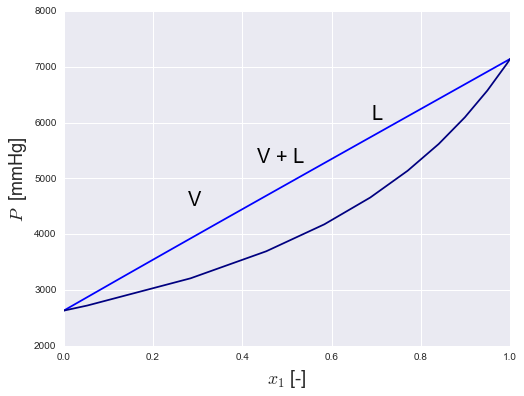

In [59]:
fig = plt.figure(figsize=(8,6))
fig.text(0.34, 0.45, "V", fontsize=20, color="k")
fig.text(0.46, 0.55, "V + L", fontsize=20, color="k")
fig.text(0.66, 0.65, "L", fontsize=20, color="k")
ax = fig.add_subplot(1,1,1)
ax.plot((xb),pb,color='blue')
#ax.scatter((1-xb),pb)
ax.plot(xd,pd,color='navy')
#ax.scatter(1-xd,pd)
ax.set_xlim([0,1])
#ax.set_ylim([0,8000])
#matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})
ax.set_xlabel(r'$x_1$ [-]', fontsize=18)
ax.set_ylabel(r'$P$  [mmHg]', fontsize=18)

In [49]:
T = 307
pentano = molecule({1:2,2:3})
acetona = molecule({1:1,18:1})
print(pentano.rql(),acetona.rql())

(3.8254, 3.316, -0.27839999999999865) (2.5735, 2.336, -0.3859999999999988)


In [50]:
acetona.rql()
acetona.phi_theta(pentano)
acetona.combinatorial(pentano)
print(acetona.phi,acetona.theta,pentano.phi,pentano.theta)
print(acetona.gamma,acetona.gamma_c_ln,pentano.gamma,pentano.gamma_c_ln)

0.970557290292 0.97184581423 0.0294427097083 0.0281541857701
0.99996355479 -3.64458739694e-05 0.933728533972 -0.0685695318525


In [51]:
acetona.psi_mod(pentano,[1,1,9])
acetona.psi_matrix

array([[ 1.        ,  1.        ,  0.21186807],
       [ 1.        ,  1.        ,  0.21186807],
       [ 0.91652483,  0.91652483,  1.        ]])

In [52]:
acetona.X_mod(pentano)
print(acetona.X)
print(acetona.Xi[1])

[0.49514563106796117, 0.029126213592233035, 0.47572815533980578]
[ 0.4  0.6]


In [53]:
print(acetona.Theta_mod(pentano))

[ 0.36719307  0.01375446  0.61905247]


In [54]:
acetona.Gamma_k(pentano)

array([ 0.39340538,  0.25051758,  0.15501976])

In [55]:
acetona.Theta_mod_i(pentano)[0]

array([ 0.3630137,  0.6369863])

In [56]:
acetona.Gamma_k_i(pentano)

(0.40890193217406967, 0.13891146087738879, 0.0, 0.0)

In [57]:
acetona.residual(pentano)

(0.096109567845172966, 1.2518700486356455)

In [58]:
A = acetona.Gamma(pentano)